# EDA

This notebook is based on an excellent [Kaggle Kernel](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-read-before-start-eda) by Gunes Evitan.


**Data Sources:**

- `data/raw/train.csv`: labelled data for approx. 7'600 tweets
- `data/raw/test.csv`: test data for approx. 3'400 tweets


**Changes**

- 2020-01-07: Start project, complete EDA

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Check-for-missing-values" data-toc-modified-id="Check-for-missing-values-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Check for missing values</a></span></li><li><span><a href="#Check-for-cardinality" data-toc-modified-id="Check-for-cardinality-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Check for cardinality</a></span></li><li><span><a href="#Anayze-Meta-Features" data-toc-modified-id="Anayze-Meta-Features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Anayze Meta Features</a></span></li><li><span><a href="#Analyze-N-grams" data-toc-modified-id="Analyze-N-grams-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Analyze N-grams</a></span></li></ul></li></ul></div>

## Import libraries, load data

In [1]:
import numpy as np
import pandas as pd
from string import punctuation

import EDA_functions as EDA
import cleaning_functions as clean

from nltk.corpus import stopwords

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')
col1, col2 = 'rebeccapurple', 'yellow'

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
df_train = pd.read_csv('data/raw/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('data/raw/test.csv', dtype={'id': np.int16})

print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024**2:.2f} MB')
print(f'Test Set Shape = {df_test.shape}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024**2:.2f} MB')

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [3]:
display(df_train.head(2))
display(df_test.head(2))

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


## EDA

In [4]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int16
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int8
dtypes: int16(1), int8(1), object(3)
memory usage: 200.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int16
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int16(1), object(3)
memory usage: 82.9+ KB


None

In [13]:
# Quick-check target distribution
df_train['target'].value_counts() / len(df_train)

0    0.57034
1    0.42966
Name: target, dtype: float64

**Observation:** Class distributions are 57% for 0 (Not Disaster) and 43% for 1 (Disaster). This means classes are quite equally separated so they don't require any stratification by `target` in cross-validation.

### Check for missing values

In [5]:
display(clean.list_NaN(df_train))
display(clean.list_NaN(df_test))

,total,percent,dtype
location,2533,33.3,object
keyword,61,0.8,object


None

,total,percent,dtype
location,1105,33.9,object
keyword,26,0.8,object


None

**Observation:** Both training and test set have the same ratio of missing values in `keyword` and `location`.So, they are most probably taken from the same sample. 

In [6]:
# missing_cols = ['keyword', 'location']

# for df in [df_train, df_test]:
#     for col in missing_cols:
#         df[col] = df[col].fillna(f'no_{col}')

### Check for cardinality

In [7]:
print(f'Nunique keyword = {df_train["keyword"].nunique()} (Training) / {df_test["keyword"].nunique()} (Test)')
print(f'Nunique location = {df_train["location"].nunique()} (Training) / {df_test["location"].nunique()} (Test)')

Nunique keyword = 221 (Training) / 221 (Test)
Nunique location = 3341 (Training) / 1602 (Test)


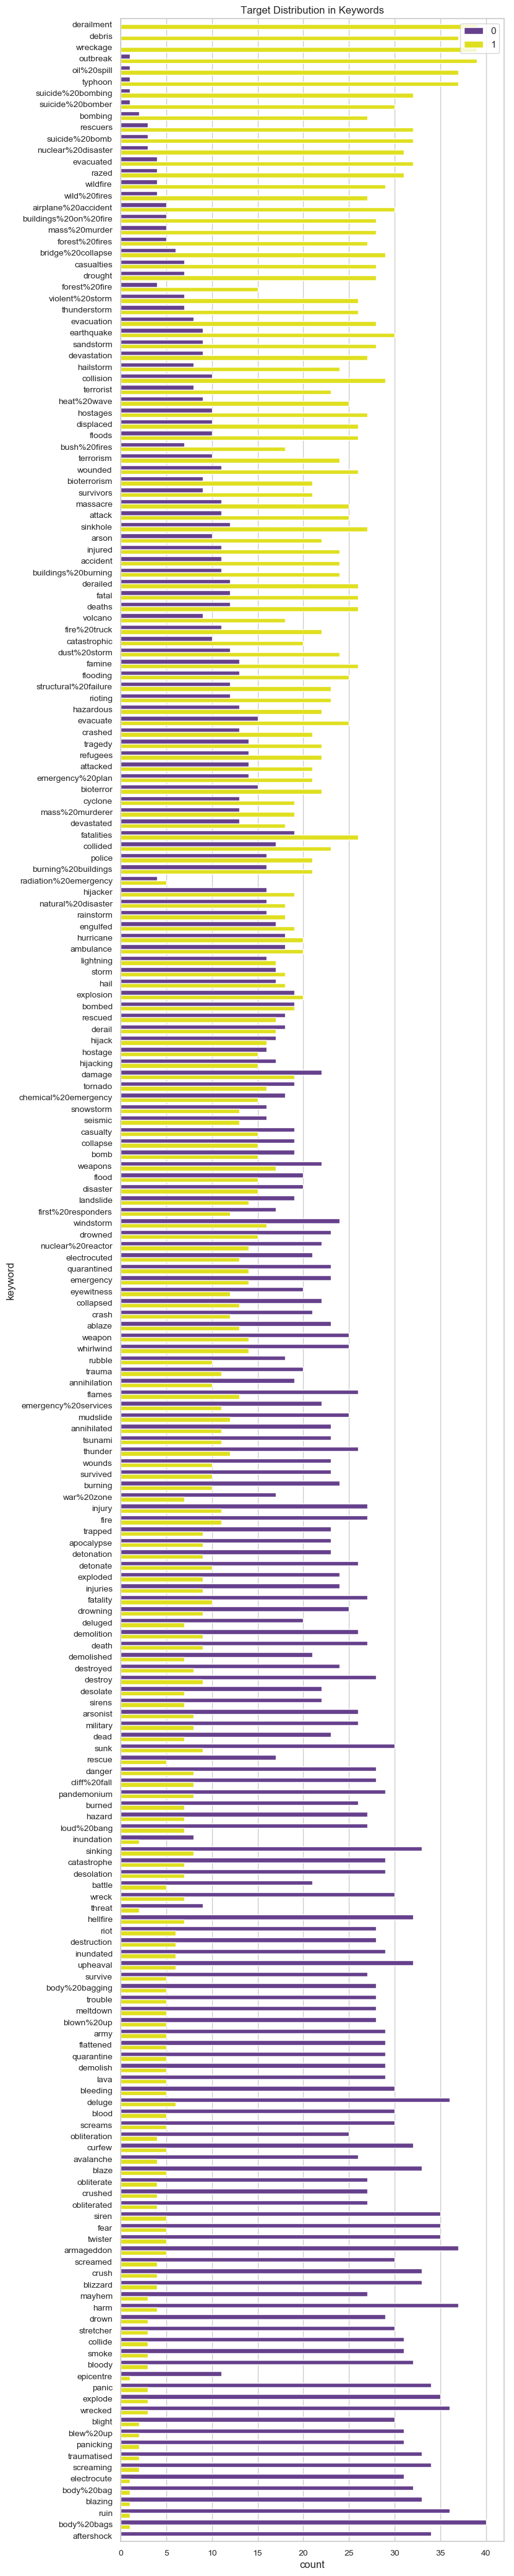

In [8]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 54), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'], 
              palette=[col1, col2])

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords');

df_train.drop(columns=['target_mean'], inplace=True)

**Observations:**
* Locations seem not to be automatically generated, they are user inputs. That's why `location` is very dirty and there are too many unique values in it. It shouldn't be used as a feature.
* In `keyword` there is signal. Keywords have very different tweet counts and target means. `keyword` can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on `keyword`.

### Anayze Meta Features
Distributions of meta features in classes and sets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [9]:
STOPWORDS = stopwords.words('english')

for df in [df_train, df_test]:
    # word_count
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    # unique_word_count
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    # stop_word_count
    df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # url_count
    df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    # mean_word_length
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # char_count
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))
    # punctuation_count
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in punctuation]))
    # hashtag_count
    df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
    # mention_count
    df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

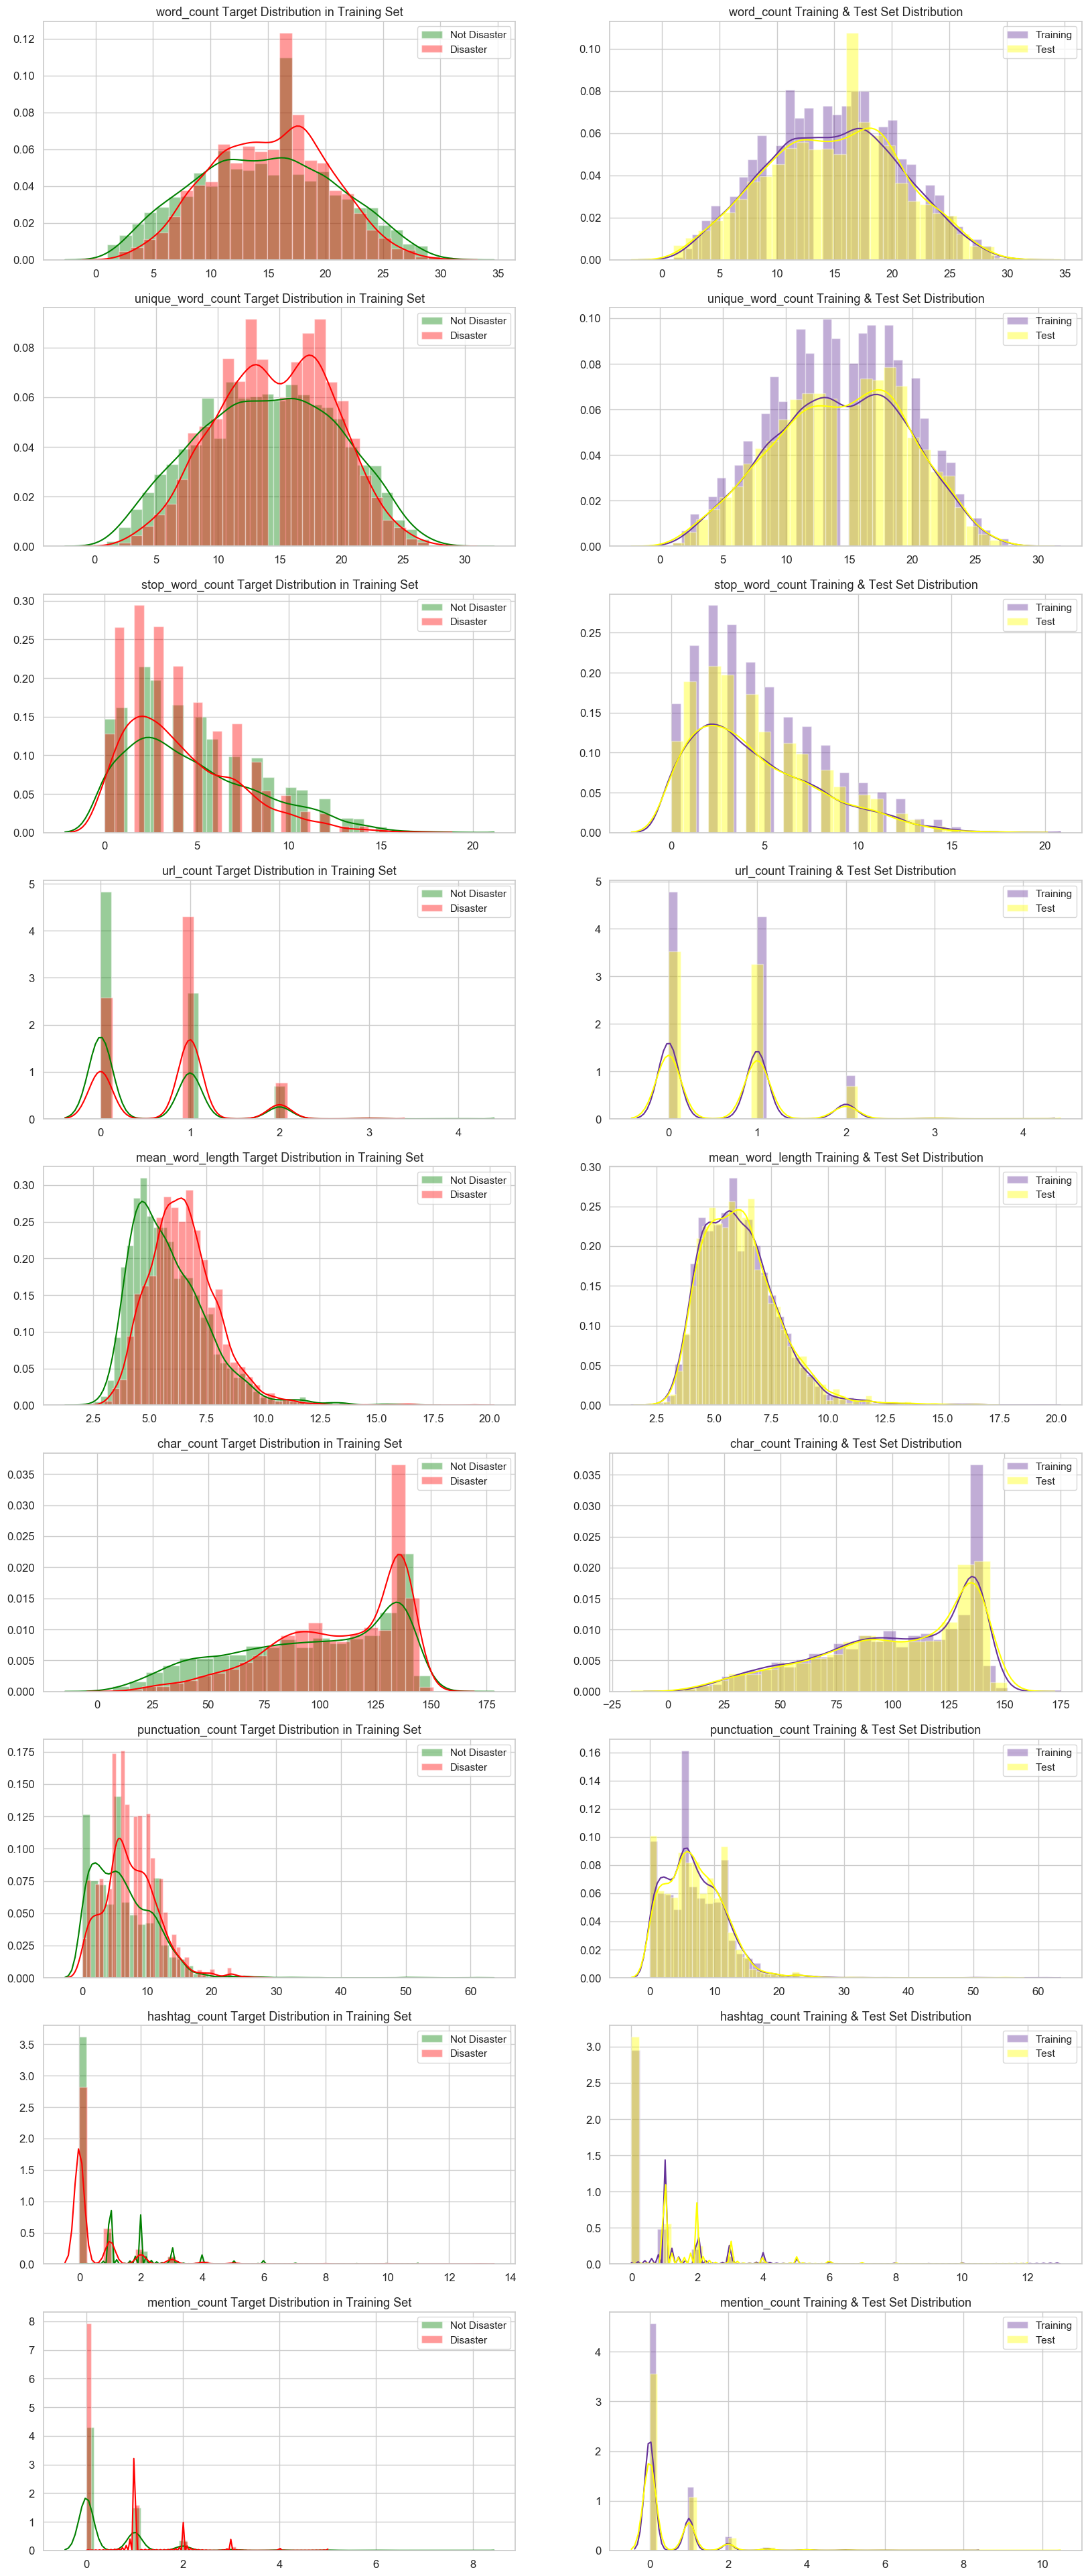

In [10]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1], color=col1)
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1], color=col2)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13);

* All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample
* All of the meta features have information about target as well, but some of them are not good enough such as `url_count`, `hashtag_count` and `mention_count`
* On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets

### Analyze N-grams

In [9]:
def generate_ngrams(text, n_gram=1):
    tokens = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[tokens[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

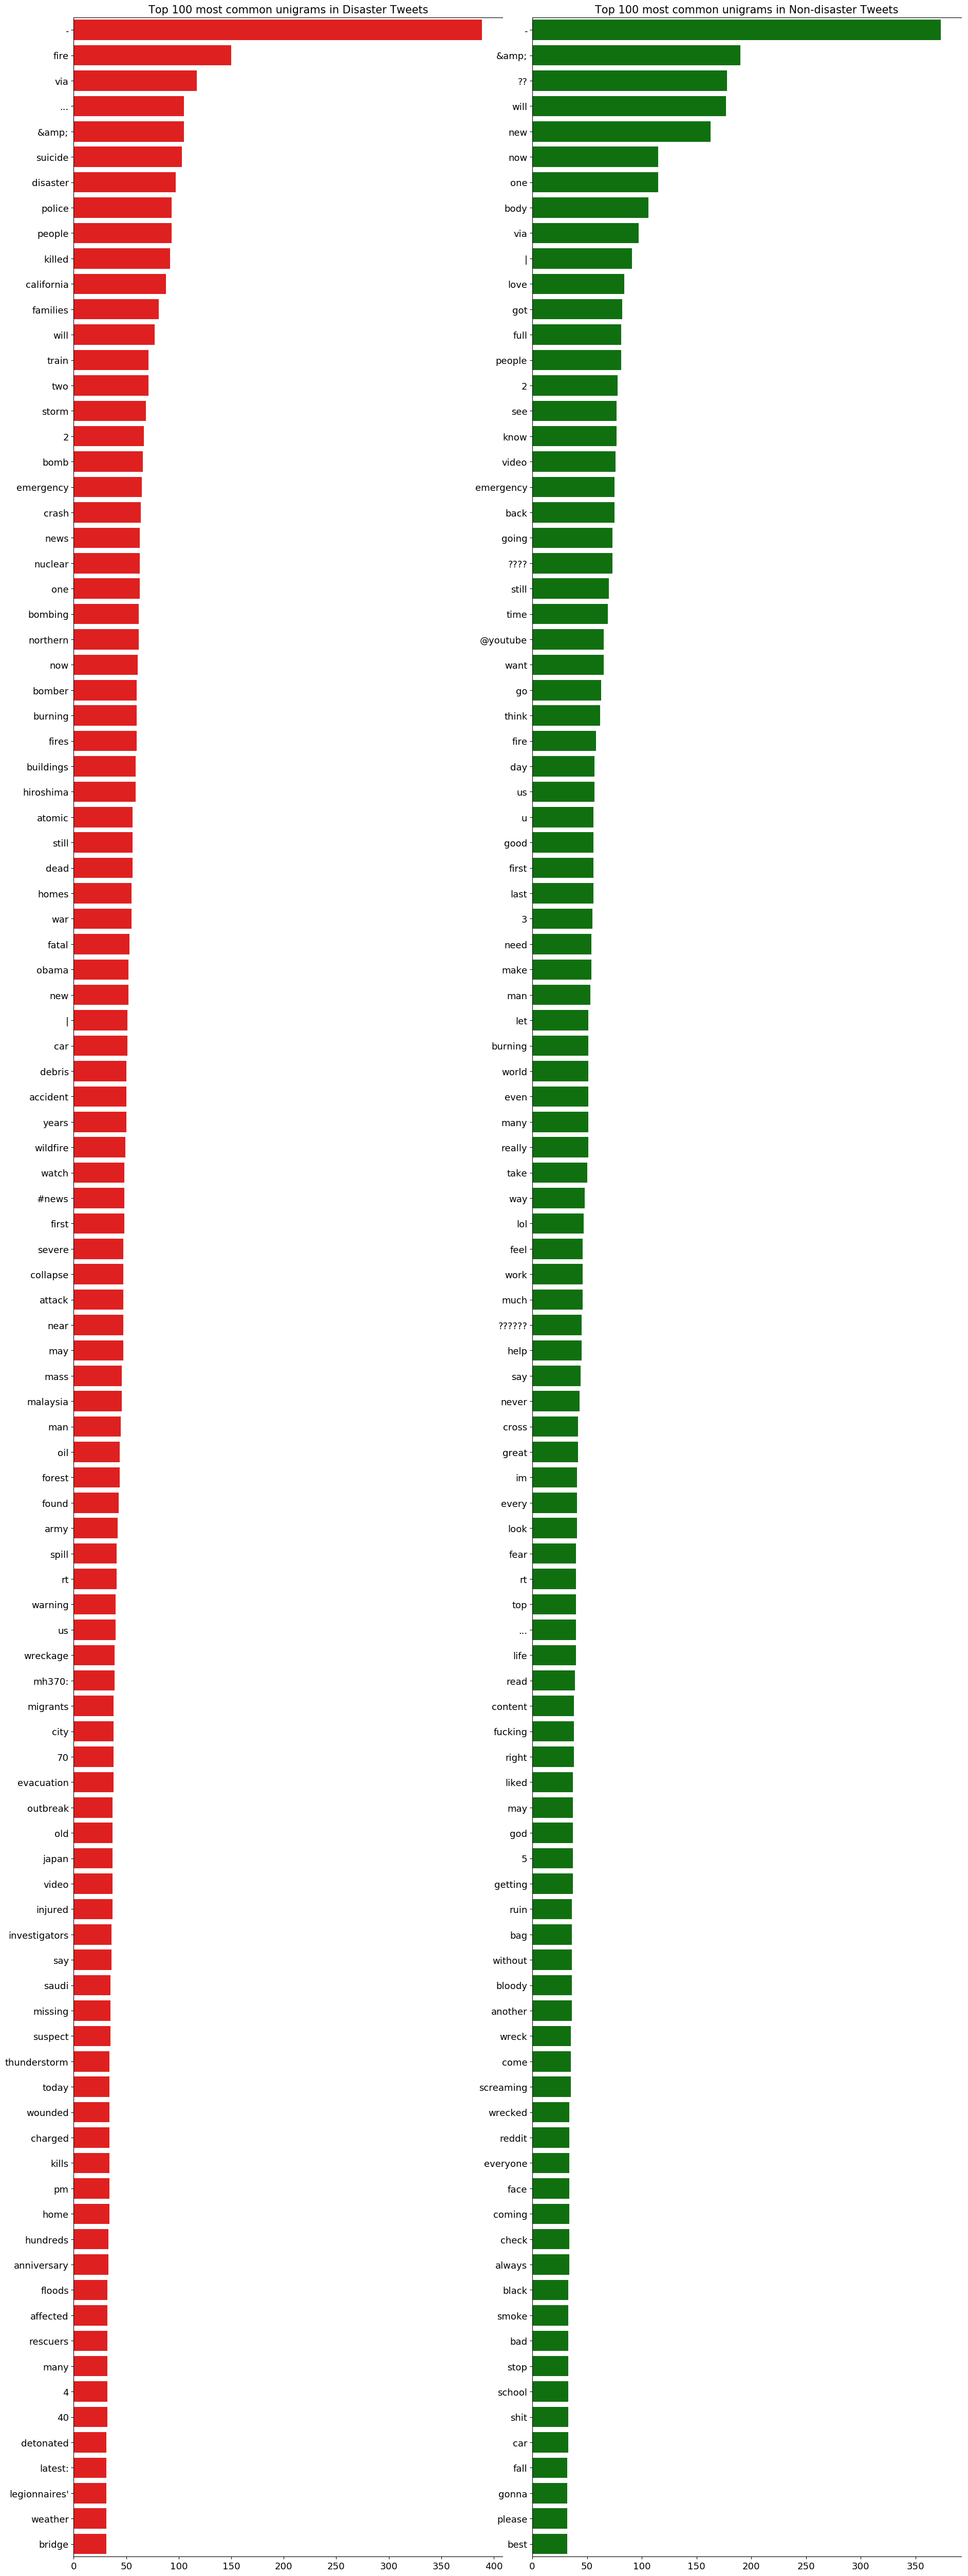

In [10]:
# Plot unigrams

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

**Observations:**
* Most common unigrams that exist in **both classes** are punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about the `target`.
* Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.
* Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

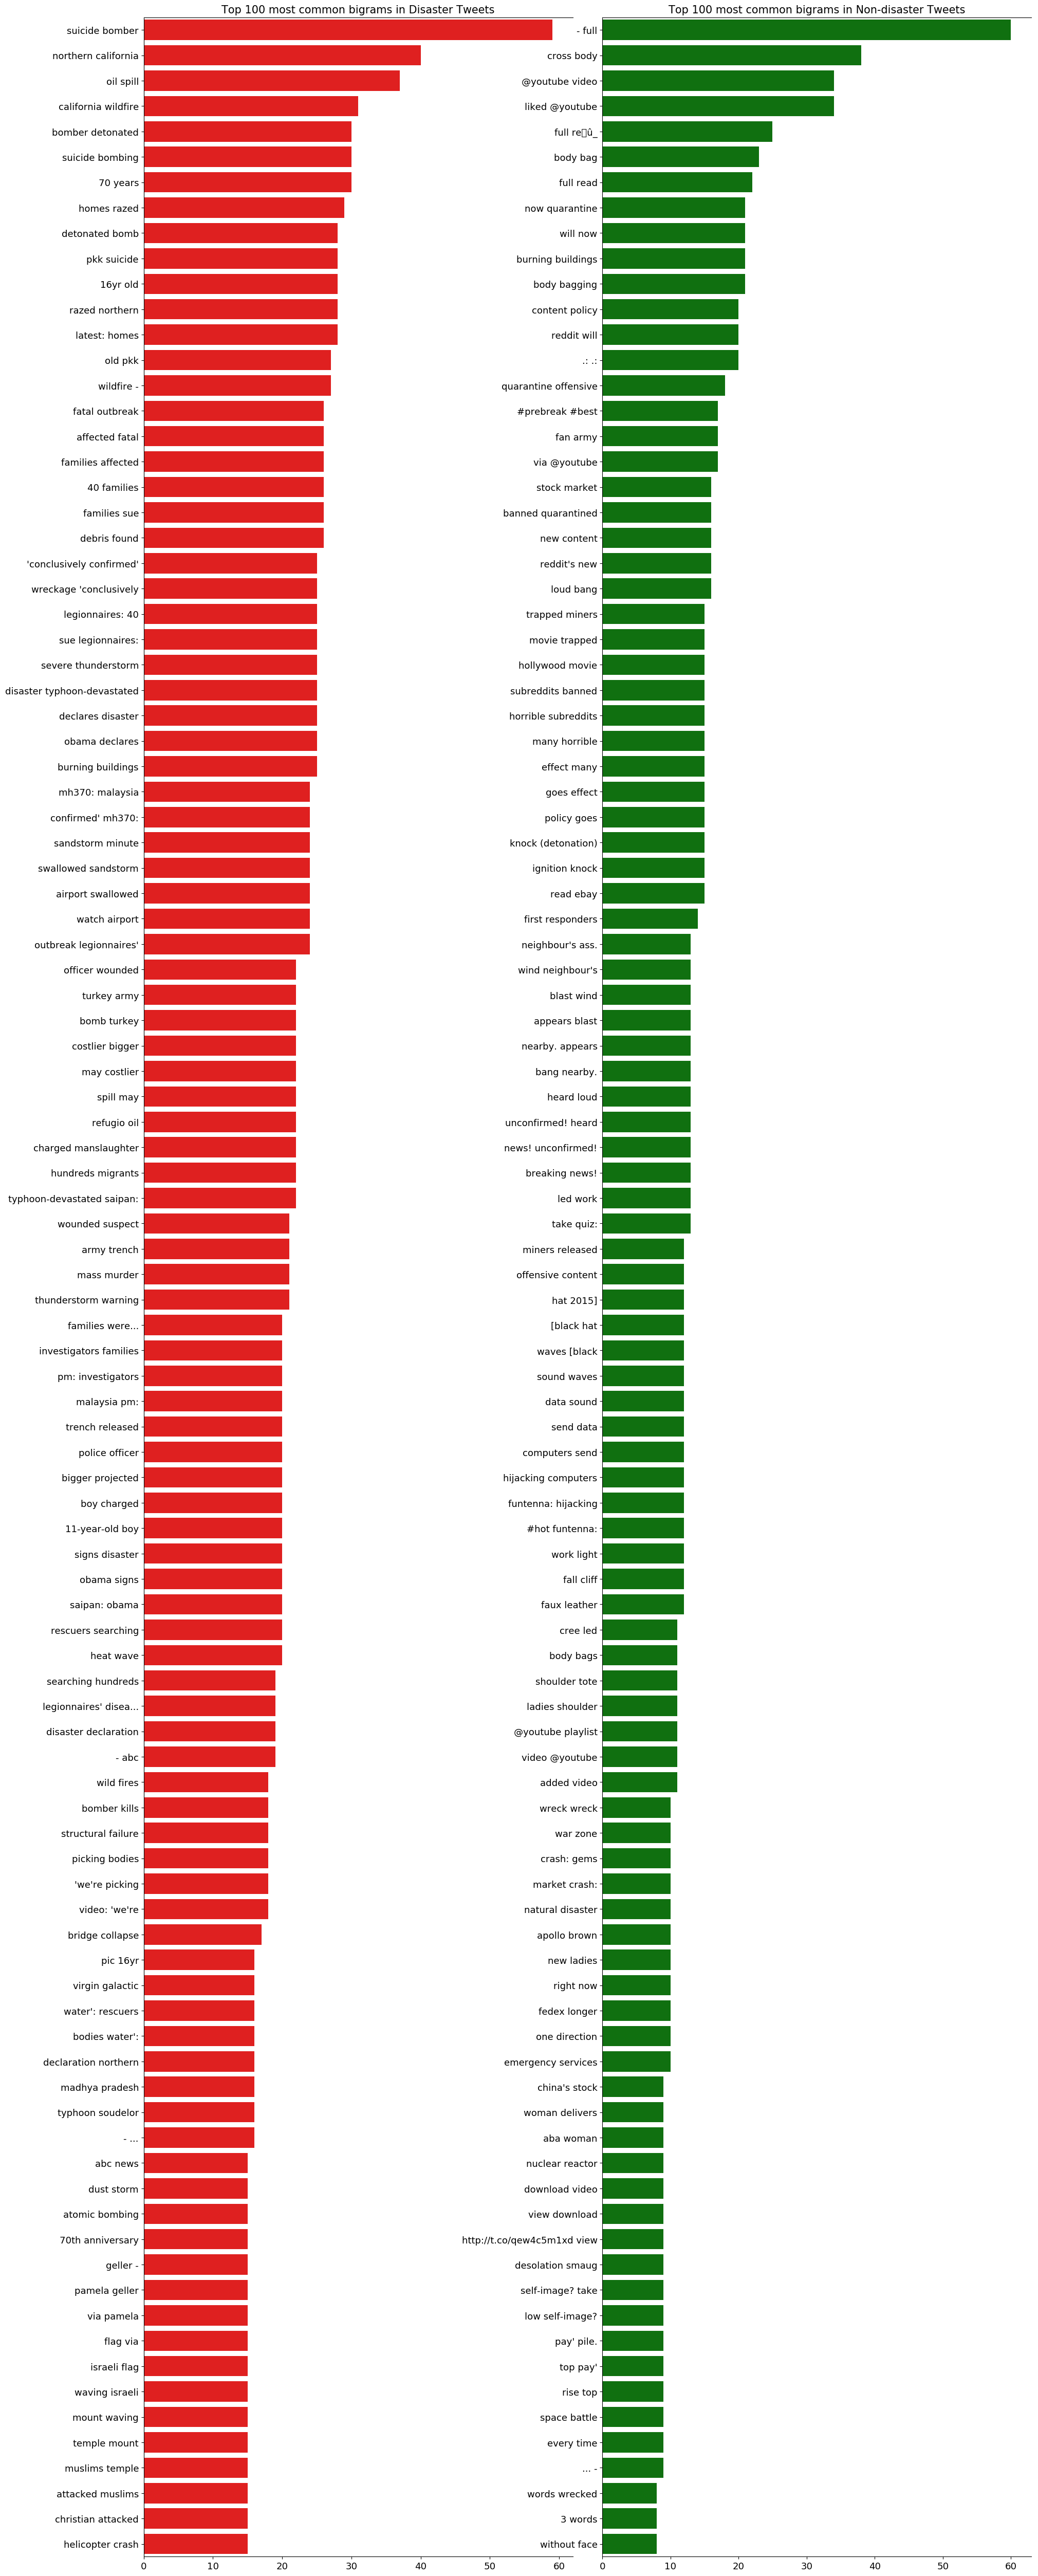

In [11]:
# Plot Bigrams

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

**Observations:**
* There are no common bigrams in the **both classes**  because the context becomes clearer.
* Most common bigrams in **disaster** tweets are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.
* Most common bigrams in **non-disaster** tweets are mostly about reddit or youtube, and they contain lots of punctuations. Those punctuations have to be cleaned out of words as well.

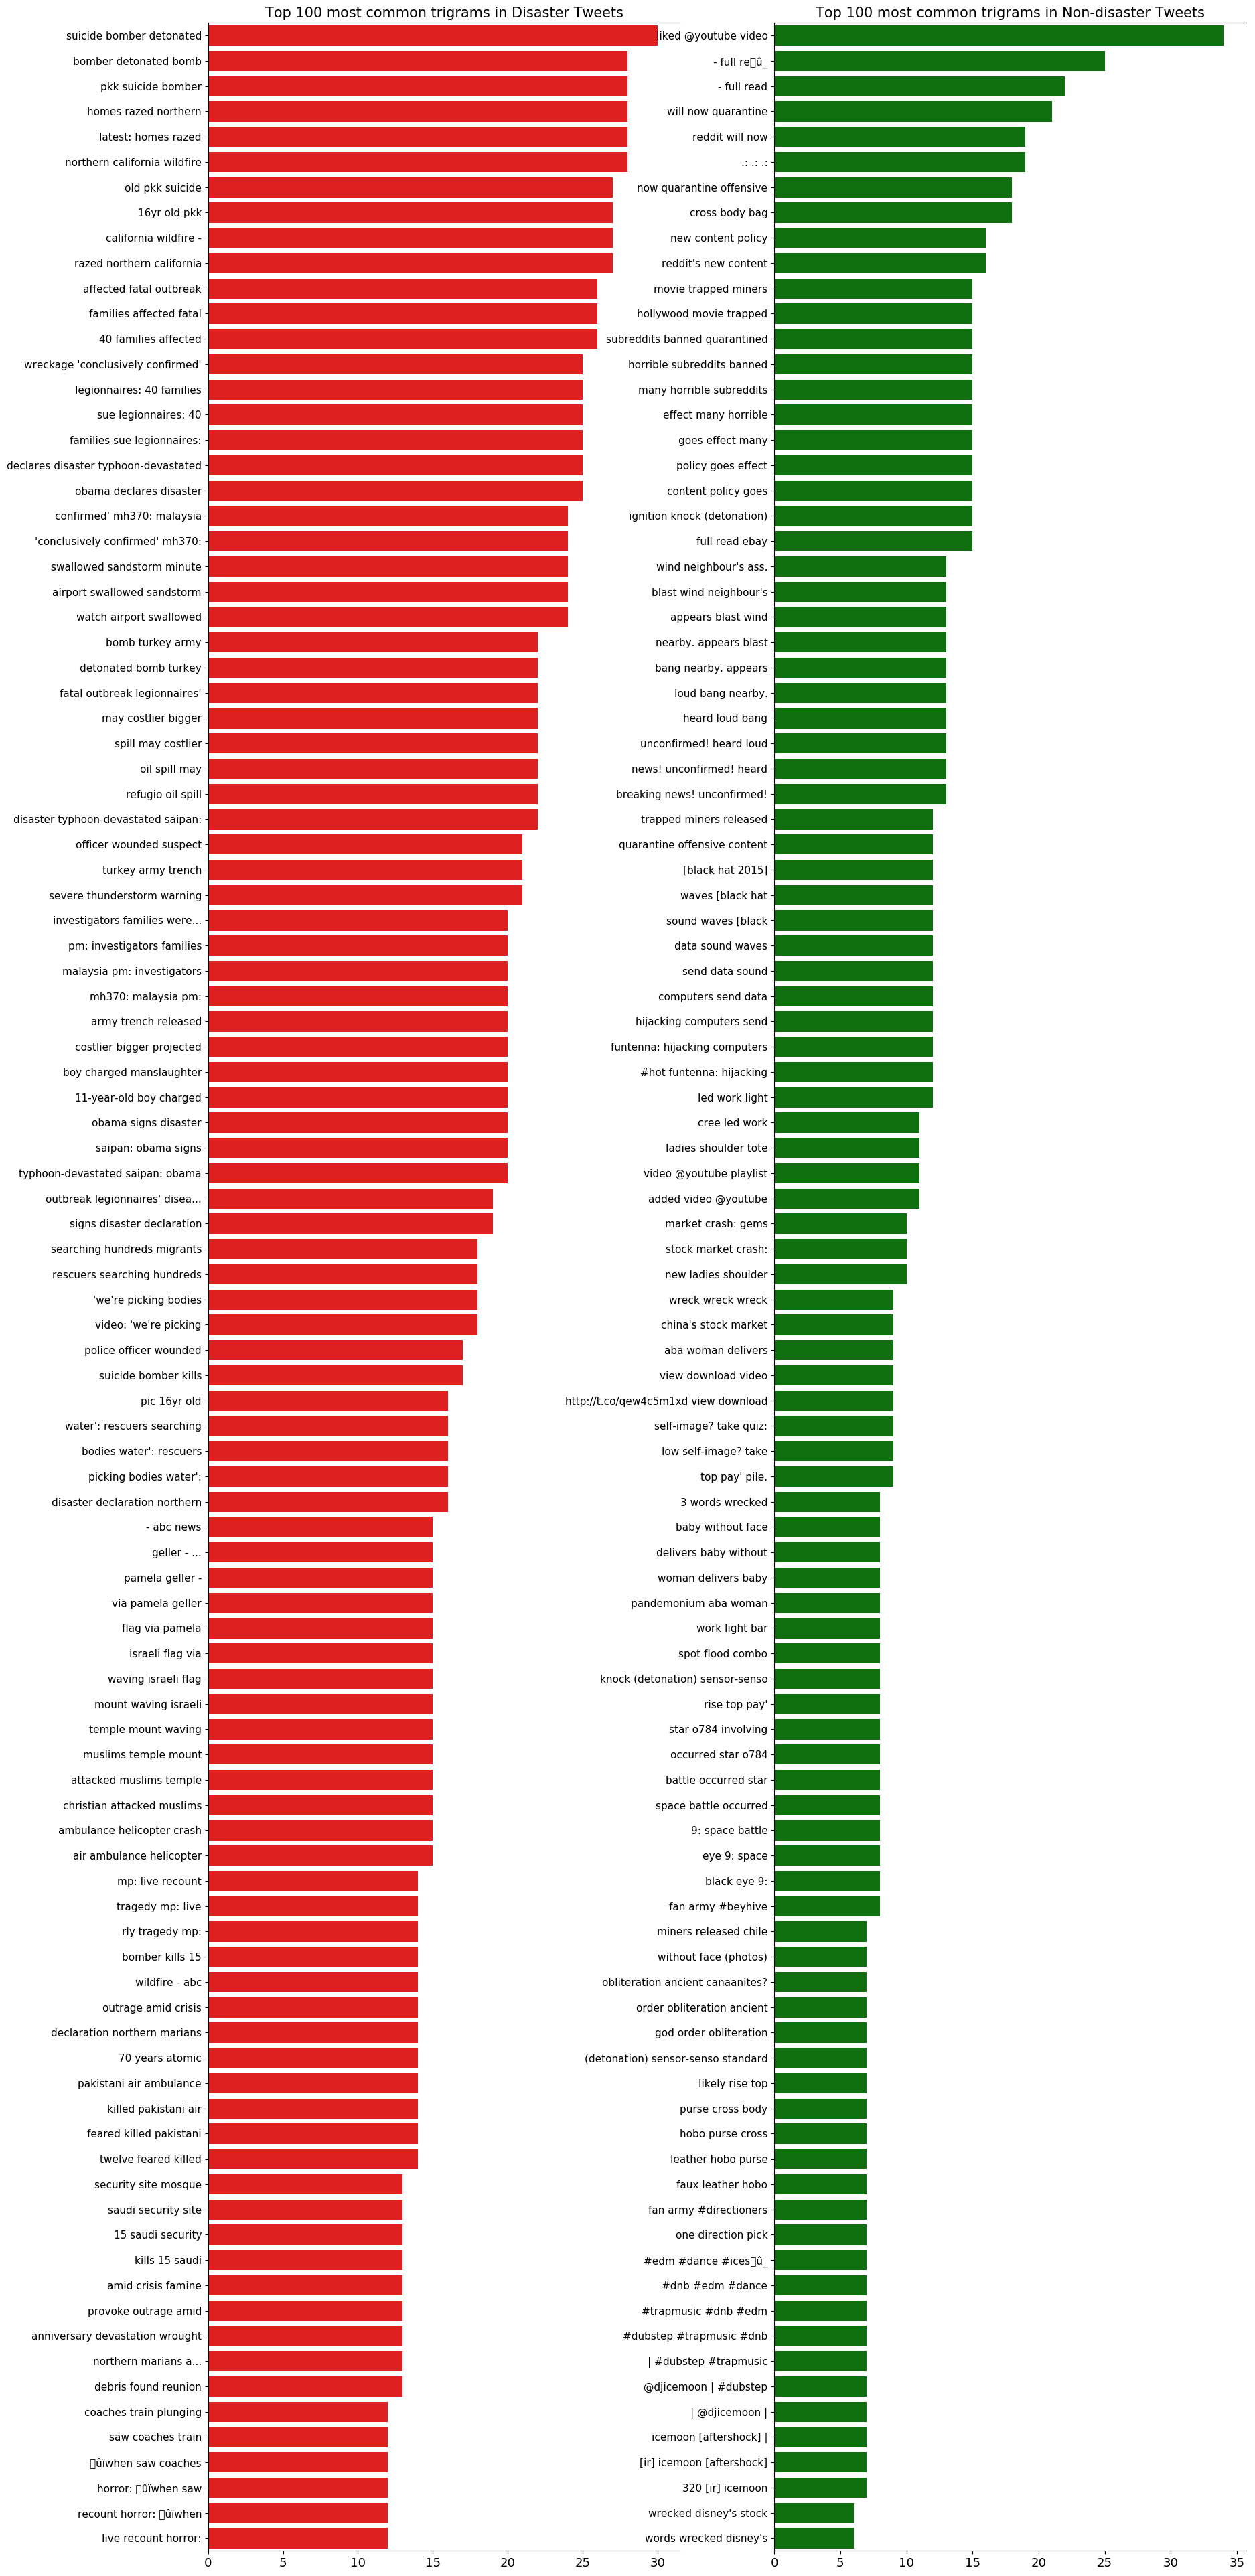

In [12]:
# Plot Trigrams

fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

**Observations:**
* There are no common trigrams exist in **both classes**  because the context is clearer.
* Most common trigrams in **disaster** tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.
* Most common trigrams in **non-disaster** tweets are also very similar to bigrams, and they contain even more punctuations.

---